# 1D Gaussian Toy Example
*Author: Mila Gorecki*

1D toy example with Guassian prior and a linear Gaussian as simulator (thus analytical solution available).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi

## Define Prior and Simulator

Gaussian prior $p(\theta) = \mathcal{N}(\theta; 0,4)$ and likelihood $p(x|\theta) = \mathcal{N}(x; \frac{1}{2}\theta+2, 3)$.

In [3]:
prior = torch.distributions.Normal(0,4).expand(batch_shape=torch.Size([1]))

# likelihood
def linear_gaussian(theta):
    # returns sample of p(x|theta): mean 0.5*theta+2, 3 std
    return 0.5*theta + 2 + torch.randn_like(theta) * 3

Sanity check: Sample and plot

In [4]:
# Draw samples
samples_prior = prior.sample([10000])
theta = torch.tensor([1.])
samples_likelihood = torch.tensor([linear_gaussian(theta) for i in range(10000)])

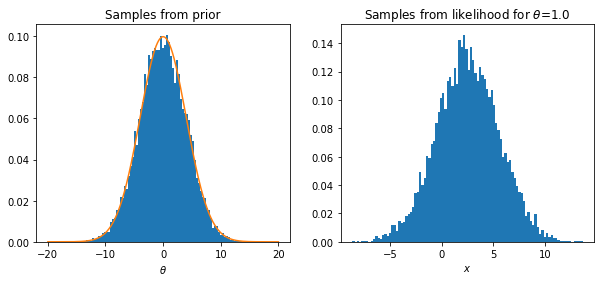

In [5]:
# Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.set_title('Samples from prior'); ax1.set_xlabel(r'$\theta$')
ax1.hist(samples_prior.numpy(), bins=100, density=True)
thetas = torch.linspace(-20,20, steps=1000)
prior_evals = prior.log_prob(thetas).exp().numpy()
ax1.plot(thetas, prior_evals)

ax2.set_title(rf'Samples from likelihood for $\theta$={theta.item()}'); ax2.set_xlabel(r'$x$')
ax2.hist(samples_likelihood.numpy(), bins=100, density=True)

plt.show()

## Define Posterior

#### Analytical Posterior and Marginal 

Gaussian prior and likelihood lead to Gaussian posterior and marginal


If <br>
prior $p(\theta)=\mathcal{N}(\theta; \mu, \Sigma) = \mathcal{N}(\theta; 0, 4)$ and <br>
likelihood $p(x|\theta) = \mathcal{N}(x; A\theta+b, \Lambda)=\mathcal{N}(x; \frac{1}{2}\theta+2, 3)$, <br>
then <br>
marginal $p(x) = \mathcal{N}(x; A\mu+b, \Lambda+A\Sigma A)=\mathcal{N}(x; 2, 4)$ and <br>
posterior $p(\theta| x) = \mathcal{N}(\theta; \mu+\Sigma A^T(A\Sigma A + \Lambda)^{-1}(x-(A\mu+b)), \Sigma-\Sigma A^T(A\Sigma A + \Lambda)^{-1}A\Sigma)=\mathcal{N}(\theta; \frac{1}{2}x-1, 3)$

In [6]:
# posterior p(theta|x)
posterior = lambda x: torch.distributions.Normal((1/2)*x-1,3)

# marginal p(x)
marginal = torch.distributions.Normal(2,4)

#### Posterior Estimation with `sbi`

Use same prior and simulator, but estimate posterior with sbi.

In [7]:
num_sim = 3000

simulator, prior = prepare_for_sbi(linear_gaussian, prior)
inference = SNPE(prior=prior)
sim_thetas, sim_xs = simulate_for_sbi(simulator, proposal=prior, num_simulations=num_sim)
inference = inference.append_simulations(sim_thetas, sim_xs)
density_estimator = inference.train()
posterior_sbi = inference.build_posterior(density_estimator)

Running 3000 simulations.: 100%|██████████| 3000/3000 [00:00<00:00, 28392.46it/s]
/Users/mgorecki/Documents/Studium/Master/4.Semester/Forschungsprojekt/posterior-ranges/sbi/neural_nets/flow.py:108: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn(f"In one-dimensional output space, this flow is limited to Gaussians")


Neural network successfully converged after 34 epochs.


#### Compare analytical and estimated posterior given a single observation

Given a single observation $x$, compare both posteriors $p(\theta|x)$.



In [8]:
x = torch.tensor([2.])
samples_sbi = posterior_sbi.sample((5000,), x).numpy()
samples_analytical = posterior(x).sample((5000,)).numpy()

Drawing 5000 posterior samples: 100%|██████████| 5000/5000 [00:00<00:00, 64091.15it/s]


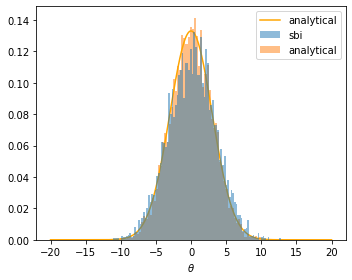

In [9]:
plt.figure(figsize=(5,4))
plt.hist(samples_sbi, bins=100, density=True, alpha=0.5, label='sbi', zorder=3)
plt.hist(samples_analytical, bins=70, density=True, alpha=0.5, label='analytical')
plt.plot(thetas, posterior(x).log_prob(thetas).exp(), color='orange', label='analytical')
plt.legend()
plt.xlabel(r'$\theta$')
plt.tight_layout()
plt.show()

## Posterior over Range

#### Rejection sampling in observation space

Sample oberservations from marginal and reject those outside the desired range to get $x\sim p(x_0 < x < x_1)$:

In [10]:
x_range = torch.tensor([[8.],[15.]])

In [11]:
n_samples = 1000
xs_accepted = [] 
while len(xs_accepted) < n_samples:
    s = marginal.sample((1,))
    if (s > x_range[0] and s < x_range[1]):
        xs_accepted.append(s)

#sim_xs_accepted = sim_xs[torch.logical_and(sim_xs>x_range[0], sim_xs<x_range[1])]

#### Posterior over range with analytical posterrior

With accepted observations $x$ evaluate posteriors on a evenly spaced interval: 

In [12]:
samples_post_range = []
for x in xs_accepted:
    samples = posterior(x).log_prob(thetas).exp().unsqueeze(dim = 0)
    samples_post_range.append(samples)
    
samples_post_range = torch.cat(samples_post_range, dim=0).numpy()

# mean over evaluted posteriors 
posterior_over_range = np.mean(samples_post_range, axis=0)

#### Posterior over range with `sbi`

In [13]:
print("Selected range: ", x_range.squeeze().tolist())

samples_post_range_sbi = []
for x in xs_accepted:
    samples = posterior_sbi.log_prob(thetas.unsqueeze(dim = 1), torch.tensor([x])).exp().unsqueeze(dim = 0) # samples of shape (1, #thetas)
    samples_post_range_sbi.append(samples)
    
samples_post_range_sbi = torch.cat(samples_post_range_sbi, dim=0).numpy()

# Monte Carlo estimate of posterior over range
posterior_over_range_sbi = np.mean(samples_post_range_sbi, axis=0)

Selected range:  [8.0, 15.0]


Use sample_range() method to get samples from specified range:

In [14]:
print("Selected range: ", x_range.squeeze().tolist())
_, samples = posterior_sbi.sample_range(x_range, sim_xs, (5000,))
_, samples_de = posterior_sbi.sample_range(x_range, sim_xs, (5000,), train_px=True)

Selected range:  [8.0, 15.0]
129 accepted observations x_i, sampling 39 from each individual posterior p(theta|x_i).
No context provided, use uncondintional MAF.
Train density estimator.
epoch | _val_log_prob | best val_log_prob
    1 |        -2.736 |            -2.736
    2 |        -2.953 |            -2.736
    3 |         -2.93 |            -2.736
    4 |        -3.124 |            -2.736
    5 |        -3.101 |            -2.736
    6 |        -2.985 |            -2.736
    7 |         -4.07 |            -2.736
    8 |         -2.87 |            -2.736
    9 |         -3.82 |            -2.736
   10 |        -2.728 |            -2.728
   11 |        -2.748 |            -2.728
   12 |        -2.763 |            -2.728
   13 |        -3.185 |            -2.728
   14 |        -3.085 |            -2.728
   15 |        -3.173 |            -2.728
   16 |        -2.751 |            -2.728
   17 |        -2.735 |            -2.728
   18 |        -2.775 |            -2.728
   19 |        

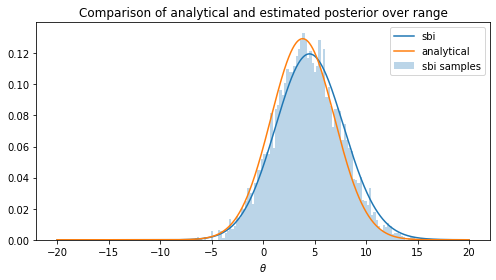

In [15]:
plt.figure(figsize=(7,4))
plt.title("Comparison of analytical and estimated posterior over range")
plt.plot(thetas, posterior_over_range_sbi, label="sbi")
plt.plot(thetas, posterior_over_range, label="analytical")
plt.hist(samples.numpy(), bins=100, density=True, color='#1f77b4', alpha=0.3, label='sbi samples')
plt.legend()
plt.xlabel(r'$\theta$')
plt.tight_layout()
plt.show()